# Log Anomaly Detection using fine tunned LLM
Classify anomaly log sequences using fine tunned LLM for BlueGene/L supercomputer system.

## Setup and Imports

In [1]:
pip install torch transformers peft datasets pandas numpy scikit-learn pyreft seaborn matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from peft import LoraConfig, get_peft_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, precision_recall_curve
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
torch.cuda.empty_cache()

---

## Data preparation

#### 1. Load Data

In [4]:
# load BGL data
log_df = pd.read_csv("./data/BGL_train.csv")

In [5]:
log_df.head(1)

,LineId,Label,Timestamp,Date,Node,Time,NodeRepeat,Type,Component,Level,Content,EventId,EventTemplate
0,1,-,1117838570,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.42.50.675872,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected,E77,instruction cache parity error corrected


#### 2. Data processing

In [6]:
# clean df
log_df.dropna()

# replace anomaly and normal labels to '1' & '0' respectively
log_df['Label'] = log_df['Label'].apply(lambda x: 0 if x == '-' else 1)

In [7]:
# combine columns to make it nore meaninful 
log_df['Description'] = '[' + log_df['Level'].astype(str) + '] ' + log_df['EventTemplate'].astype(str)

In [8]:
log_df.head(1)

,LineId,Label,Timestamp,Date,Node,Time,NodeRepeat,Type,Component,Level,Content,EventId,EventTemplate,Description
0,1,0,1117838570,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.42.50.675872,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected,E77,instruction cache parity error corrected,[INFO] instruction cache parity error corrected


In [9]:
print(log_df['Label'].value_counts())

Label
0    1857
1     143
Name: count, dtype: int64


#### 3. Sequence windowing

In [10]:
# each sequence window size
window_size = 10
# how much window to slide 
stride = 3

sequences = []
labels = []

# combines 10 consecutive rows into a one sequence
for i in range(0, len(log_df) - window_size + 1, stride):
    sequence = ' '.join(log_df['Description'][i:i + window_size].astype(str))
    seq_label = log_df['Label'][i:i + window_size].max()
    sequences.append(sequence)
    labels.append(seq_label)

#### 4. Train Test split

In [11]:
# split sequences and labels into - 80% training & 20% testing
train_seqs, test_seqs, train_labels, test_labels = train_test_split(
    sequences, labels, test_size=0.2, random_state=42
)

print(f"Total sequences: {len(train_seqs) + len(test_seqs)}")
print(f"Train sequences: {len(train_seqs)} | Anomalous: {sum(train_labels)} ({sum(train_labels)/len(train_labels)*100:.2f}%)")
print(f"Test sequences: {len(test_seqs)} | Anomalous: {sum(test_labels)} ({sum(test_labels)/len(test_labels)*100:.2f}%)")

Total sequences: 664
Train sequences: 531 | Anomalous: 98 (18.46%)
Test sequences: 133 | Anomalous: 32 (24.06%)


---

## Tokenization & Dataset creation

#### 1. Setup tokenizer

In [12]:
llm_model = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
tokenizer = AutoTokenizer.from_pretrained(llm_model)

# utility function to convert logs into model ready inputs 
def tokenize_sequences(sequences, tokenizer, max_length=512):
    return tokenizer(
        sequences,
        truncation=True,
        padding=True,
        max_length=max_length,
        return_tensors='pt'
    )

#### 2. Dataset creation

In [13]:
# convert to PyTorch dataset
class LogDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

#### 3. Tokenize sequences

In [14]:
# tokenize
train_encodings = tokenize_sequences(train_seqs, tokenizer)
test_encodings = tokenize_sequences(test_seqs, tokenizer)

# create datasets
train_dataset = LogDataset(train_encodings, train_labels)
test_dataset = LogDataset(test_encodings, test_labels)

# create loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)

---

## Model Training

#### 1. Prepare model training

In [15]:
# function to train the model
def train_model(model, train_loader, test_loader, device, epochs=10, patience=5):
    model.to(device)
    # intialise AdamW optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    # small learning rate so it won’t overshoot
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    # handle classs imbalance with higher weight
    # weighted loss to penalize for misclassifying the minority class
    class_weights = torch.tensor([1.0, 6.0]).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
        
    # track early stopping
    best_f1 = 0
    patience_counter = 0

    print(f"\nTraining... | No. of Epochs: {epochs}...\n")
    
    # Train model
    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for batch in train_loader:

            # reset gradient
            optimizer.zero_grad()

            # Get the input data and labels from the batch, move them to the device (GPU/CPU)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            
            labels = batch['labels'].to(device)

            # forward pass
            outputs = model(input_ids, attention_mask=attention_mask)
            
            # calculate loss
            loss = criterion(outputs.logits, labels)
                        
            # backward pass
            loss.backward()
                        
            # update model weight
            optimizer.step()

            # Accumulate the loss for logging purposes
            total_loss += loss.item()

        # adjust learning rate
        scheduler.step()
        # average loss for the epoch
        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}")
        
        # Evaluate to check for early stopping
        f1, _, _, _ = evaluate_model(model, test_loader, device)
        if f1 > best_f1:
            best_f1 = f1
            patience_counter = 0
            torch.save(model.state_dict(), 'anomaly_model.pt')
            print("\n########################################\n")
        else:
            # If no improvement in F1 score, stop training early
            patience_counter += 1
            if patience_counter >= patience:
                print("\nEarly stopping...\n")
                break

#### 2. Prepare model evaluation

In [16]:
# evaluate model performance with threshold
def evaluate_model(model, test_loader, device, threshold=0.1039):
    # evaluate
    model.eval()
    predictions = []
    true_labels = []

    # disable gradient
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # forward pass
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits[:, 1]  # Score for class 1

            # predict anomaly
            preds = (logits > threshold).cpu().numpy().astype(int)

            # store predeiction
            predictions.extend(preds)
            true_labels.extend(labels.cpu().numpy())

    # calcuate metrics
    f1 = f1_score(true_labels, predictions, zero_division=0)
    precision = precision_score(true_labels, predictions, zero_division=0)
    recall = recall_score(true_labels, predictions, zero_division=0)
    
    print(f"\nF1: {f1:.4f}\nPrecision: {precision:.4f}\nRecall: {recall:.4f}\n")
    print(f"Confusion Matrix:\n {confusion_matrix(true_labels, predictions)}\n")
    return f1, precision, recall, predictions

#### 3. Initialise model

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load model
model = AutoModelForSequenceClassification.from_pretrained(
    llm_model,
    num_labels=2
)

# set padding & update model
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.padding_side = 'right'
model.config.pad_token_id = tokenizer.pad_token_id

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at TinyLlama/TinyLlama-1.1B-Chat-v1.0 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### 4. Setup Lora

In [18]:
# define lora
lora_config = LoraConfig(
    task_type="SEQ_CLS", # for binary classification
    r=32,
    lora_alpha=64,
    lora_dropout=0.1,
    target_modules=["q_proj", "v_proj", "k_proj"]
)
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

trainable params: 6,131,712 || all params: 1,040,648,192 || trainable%: 0.5892


#### 5. Train model

In [19]:
# train model
train_model(model, train_loader, test_loader, device, epochs=10, patience=5)


Training... | No. of Epochs: 10...

Epoch 1, Loss: 0.46462483032703844

F1: 0.7500
Precision: 0.6250
Recall: 0.9375

Confusion Matrix:
 [[83 18]
 [ 2 30]]


########################################

Epoch 2, Loss: 0.15210731099220687

F1: 0.8485
Precision: 0.8235
Recall: 0.8750

Confusion Matrix:
 [[95  6]
 [ 4 28]]


########################################

Epoch 3, Loss: 0.04048214884691089

F1: 0.9062
Precision: 0.9062
Recall: 0.9062

Confusion Matrix:
 [[98  3]
 [ 3 29]]


########################################

Epoch 4, Loss: 0.007022040944117288

F1: 0.9091
Precision: 0.8824
Recall: 0.9375

Confusion Matrix:
 [[97  4]
 [ 2 30]]


########################################

Epoch 5, Loss: 0.0018351057671082602

F1: 0.9375
Precision: 0.9375
Recall: 0.9375

Confusion Matrix:
 [[99  2]
 [ 2 30]]


########################################

Epoch 6, Loss: 0.0011038627996111164

F1: 0.9375
Precision: 0.9375
Recall: 0.9375

Confusion Matrix:
 [[99  2]
 [ 2 30]]

Epoch 7, Loss: 0.001008

---

## Modal Evaluation

#### 1. Evaluate model

In [32]:
# load model for evaluation
model.load_state_dict(torch.load('anomaly_model.pt'))
# evaluate
_, _, _, predictions = evaluate_model(model, test_loader, device, threshold=0.1039)


F1: 0.9375
Precision: 0.9375
Recall: 0.9375

Confusion Matrix:
 [[99  2]
 [ 2 30]]



#### 2. Evaluate with threshold tuning

In [33]:
# find best threshold based on F1 score
def evaluate_model_with_threshold(model, test_loader, device):
    # evaluate
    model.eval()
    logits = []
    true_labels = []
    
    # disable gradient
    with torch.no_grad():
        for batch in test_loader:
            # move batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # forward pass
            outputs = model(input_ids, attention_mask=attention_mask)
            logits.extend(outputs.logits[:, 1].cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            
    from sklearn.metrics import precision_recall_curve

    # calculate precision & recall
    precisions, recalls, thresholds = precision_recall_curve(true_labels, logits)
    # F1 score
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
    # index of best F1 score
    best_idx = f1_scores.argmax()

    # best threshold
    best_threshold = thresholds[best_idx]
    
    print(f"\nBest F1: {f1_scores[best_idx]:.4f}\nPrecision: {precisions[best_idx]:.4f}\n"
          f"Recall: {recalls[best_idx]:.4f}\nThreshold: {best_threshold:.4f}\n")

    return true_labels, logits, best_threshold

In [34]:
# find best threshold
true_labels, logits, best_threshold = evaluate_model_with_threshold(model, test_loader, device)


Best F1: 0.9375
Precision: 0.9375
Recall: 0.9375
Threshold: 0.3221



#### 3. Re-evaluate with best threshold

In [35]:
evaluate_model(model, test_loader, device, threshold=best_threshold)


F1: 0.9206
Precision: 0.9355
Recall: 0.9062

Confusion Matrix:
 [[99  2]
 [ 3 29]]



(0.9206349206349206,
 0.9354838709677419,
 0.90625,
 [0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  1,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0])

#### 4. Plot confusion matrix

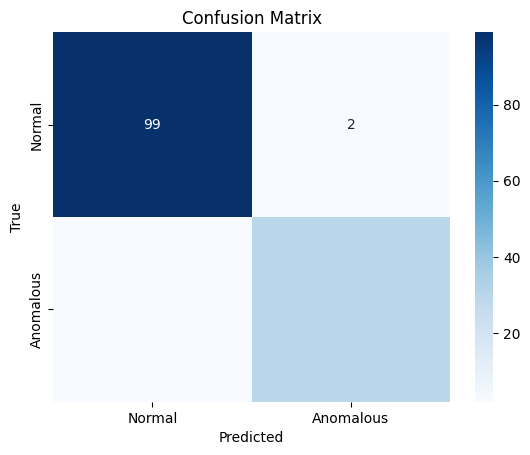

In [36]:
# calculate & plot
cm = confusion_matrix(true_labels, predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomalous'], yticklabels=['Normal', 'Anomalous'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#### 4. Plot Precission Recall curve

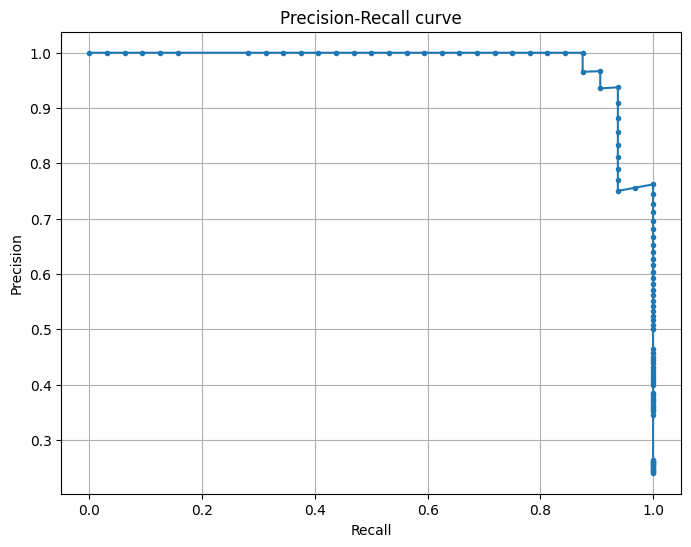

In [37]:
# calculate & plot
precisions, recalls, thresholds = precision_recall_curve(true_labels, logits)
plt.figure(figsize=(8,6))
plt.plot(recalls, precisions, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.grid()
plt.show()

---